In [1]:
%matplotlib inline

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn

import pymongo

In [2]:
# As we have A LOT of data in mongodb cursor and
# pandas is still unable to create dataframe from generator object
# will pretend our cursor to be CSV fobj

class MongoCSVAdapter(object):
    
    def __init__(self, cursor, fields=None, splitter="/"):
        self.cursor = cursor
        self.fields = fields
        self.splitter = splitter
        self.times_called = 0
        self.values_per_time = 10
        self.line_ending = '\n'
    
    def read(self, n=0):
        try:
            self.times_called += 1
            values = [self._row_from_el(next(cursor)) + self.line_ending
                      for _ in range(self.values_per_time)]
            result = "".join(values)
            
            return result
        except StopIteration:
            return ''
    
    def _row_from_el(self, row):
        row = self.splitter.join((row[k] for k in self.fields)).strip()
        return row

In [3]:
client = pymongo.MongoClient()
fields = ['title', 'year', 'type', 'genre']
cursor = client.movies_db.movies_collection.find({}, fields)

adapter = MongoCSVAdapter(cursor, fields=fields)

# Get all movies from the collection
movies = pd.read_csv(adapter, sep='/', names=fields)

In [4]:
# We are only interested in movies
movies = movies[movies['type'] == 'movie']

# We are now not interested in type column so we may drop it
# for performance sake
movies.drop('type', axis=1, inplace=True)
movies.drop('title', axis=1, inplace=True)

In [71]:
part = movies.copy()
splitted_genres = part.genre.str.split(",")
splitted_genres = splitted_genres.apply(pd.Series, 1).stack()

s = splitted_genres.copy()

s.index = s.index.droplevel(-1)
s.name = 'genre'

del part['genre']
splitted_genres = part.join(s)

splitted_genres.tail()

,year,genre
1117588,1912,Short
1117588,1912,Drama
1117591,2006,Documentary
1117597,1912,Documentary
1117597,1912,Short


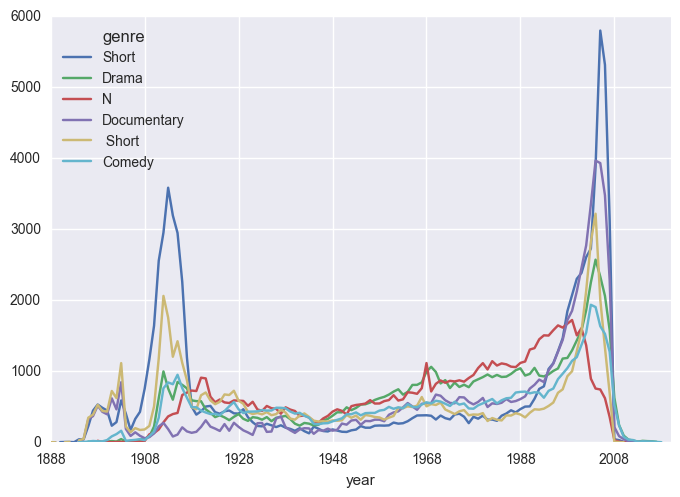

In [73]:
genre_counts = splitted_genres.groupby('year')['genre'].value_counts()
# genre_counts
pew = genre_counts.unstack()
seven_most_popular = [n for n in pew.sum().nlargest(6).index]
seven_most_popular

most_popular_df = pew[seven_most_popular]

most_popular_df.plot()
# plt.plot(pew['Action'], pew.index)
# plt.xlabel('Year')
# plt.ylabel('Number of movies')